# Part 1
Answering key business questions from Instacart. The goal will be to provide better insight for customer profiling in terms of ads, bonus programs, and sales information.

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
# Setting Path
path = r'/Users/pierremora/Desktop/08:20:2023 INSTACART BASKET ANALYSIS'

In [5]:
# Importing  dataframe
ords_prods_custmerged= pd.read_pickle(os.path.join(path, 'Data', 'Prepared Data', 'ords_prods_cust_merged.pkl'))

In [6]:
# looking for PII data on the dataframe
ords_prods_custmerged.dtypes

user_id                     object
first_name                  object
last_name                   object
gender                      object
state                       object
age                          int64
number_of_dependants         int64
fam_status                  object
total_income                 int64
order_id                    object
number_of_orders             int32
order_day_of_week             int8
order_hour_of_day            int16
days_since_prior_order     float64
product_id                  object
product_name                object
department_id                int16
prices                     float64
price_range_loc             object
busiest_day                 object
busiest_days                object
busiest_period_of_day       object
max_order                  float64
loyalty_flag                object
avg_price                  float64
spending_flag               object
median_order_day           float64
frequency_flag              object
_merge              

In the DataFrame, the following columns may contain PII:

* user_id (assuming it contains identifiable information)
* first_name
* last_name
* gender
* state

In [7]:
# Creating a new DataFrame without PII columns
df_without_pii = ords_prods_custmerged.drop(columns=['first_name', 'last_name'])


# Comparing customer behavior in different geographic areas.

In [8]:
# Define a dictionary mapping states to regions, including all 50 states and the District of Columbia
state_to_region = {
    # Region 1 (Northeast)
    'Connecticut': 'Region 1', 'Delaware': 'Region 1', 'Maine': 'Region 1',
    'Maryland': 'Region 1', 'Massachusetts': 'Region 1', 'New Hampshire': 'Region 1',
    'New Jersey': 'Region 1', 'New York': 'Region 1', 'Pennsylvania': 'Region 1',
    'Rhode Island': 'Region 1', 'Vermont': 'Region 1', 'District of Columbia': 'Region 1',

    # Region 2 (Midwest)
    'Illinois': 'Region 2', 'Indiana': 'Region 2', 'Iowa': 'Region 2',
    'Kansas': 'Region 2', 'Michigan': 'Region 2', 'Minnesota': 'Region 2',
    'Missouri': 'Region 2', 'Nebraska': 'Region 2', 'North Dakota': 'Region 2',
    'Ohio': 'Region 2', 'South Dakota': 'Region 2', 'Wisconsin': 'Region 2',

    # Region 3 (South)
    'Alabama': 'Region 3', 'Arkansas': 'Region 3', 'Florida': 'Region 3',
    'Georgia': 'Region 3', 'Kentucky': 'Region 3', 'Louisiana': 'Region 3',
    'Mississippi': 'Region 3', 'North Carolina': 'Region 3', 'Oklahoma': 'Region 3',
    'South Carolina': 'Region 3', 'Tennessee': 'Region 3', 'Texas': 'Region 3',
    'Virginia': 'Region 3', 'West Virginia': 'Region 3',

    # Region 4 (West)
    'Alaska': 'Region 4', 'Arizona': 'Region 4', 'California': 'Region 4',
    'Colorado': 'Region 4', 'Hawaii': 'Region 4', 'Idaho': 'Region 4',
    'Montana': 'Region 4', 'Nevada': 'Region 4', 'New Mexico': 'Region 4',
    'Oregon': 'Region 4', 'Utah': 'Region 4', 'Washington': 'Region 4',
    'Wyoming': 'Region 4',

   
}

# Create the 'Region' column based on the 'State' column
df_without_pii['Region'] = df_without_pii['state'].map(state_to_region)





In [9]:
#checking for values
df_without_pii['Region'].value_counts(dropna=False)

Region
Region 4    4327898
Region 3    4317220
Region 1    3868787
Region 2    3624456
Name: count, dtype: int64

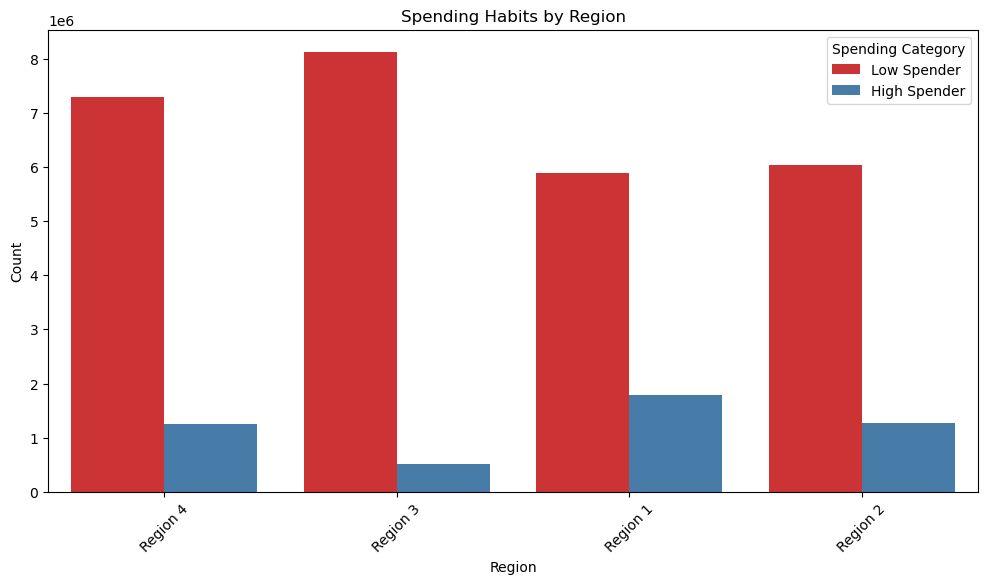

In [28]:
# Creating a bar chart for spending habits by region and category
bar = plt.figure(figsize=(12, 6))
sns.countplot(data=df_without_pii, x='Region', hue='spending_flag', palette='Set1')
plt.title('Spending Habits by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Spending Category', labels=['Low Spender', 'High Spender'])
plt.show()


In [29]:
# Saving the bar as a PNG
bar.figure.savefig(os.path.join(path, 'Analysis','Visualizations', 'bar_region_spending.png'))

# Creating an exclusion flag for low-activity customers(customers with less than 5 orders)

In [10]:
# creating exclusion flag
df_without_pii.loc[df_without_pii['number_of_orders'] < 5 , 'exclusion_flag'] = 'low-active customer'


In [11]:
df_without_pii.loc[df_without_pii['number_of_orders'] >= 5 , 'exclusion_flag'] = 'active customer'

In [12]:
df_without_pii['exclusion_flag'].value_counts(dropna= False)

exclusion_flag
active customer        12169265
low-active customer     3969096
Name: count, dtype: int64

In [13]:
# Excluding low-active customers from the database
# Creating a new DataFrame with only 'active customer' rows
active_customer_df = df_without_pii[df_without_pii['exclusion_flag'].isin(['active customer'])]


In [14]:
# exporting SAMPLE
# Export data to pkl

active_customer_df.to_pickle(os.path.join(path, 'Data','Prepared Data', 'active_customers_ords_prods.pkl'))

# Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents. 

In [15]:
# importing department_id dataframe
df_dep = pd.read_csv(os.path.join(path, 'Data', 'Original Data', 'depart.csv'), index_col = False)

In [16]:
df_dep_t = df_dep.T

In [17]:
df_dep_t.reset_index()

,index,0
0,department_id,department
1,1,frozen
2,2,other
3,3,bakery
4,4,produce
5,5,alcohol
6,6,international
7,7,beverages
8,8,pets
9,9,dry goods pasta


In [18]:
# taking the first row of the dataframe for header
new_header = df_dep_t.iloc[0]

In [19]:
df_dep_t_new = df_dep_t[1:]

In [20]:
df_dep_t_new.columns = new_header

In [21]:
df_dep_t_new

department_id,department
1,frozen
2,other
3,bakery
4,produce
5,alcohol
6,international
7,beverages
8,pets
9,dry goods pasta
10,bulk


In [22]:
data_dict = df_dep_t_new.to_dict('index')

In [23]:
#ccounting fam_status values
df_without_pii['fam_status'].value_counts(dropna=False)

fam_status
married                             12202927
single                               2503706
divorced/widowed                     1167626
living with parents and siblings      264102
Name: count, dtype: int64

In [24]:
#ccounting number_of_dependants values
df_without_pii['number_of_dependants'].value_counts(dropna=False)

number_of_dependants
3    4847005
2    3931684
1    3688340
0    3671332
Name: count, dtype: int64

In [25]:
#ccounting total_income values
df_without_pii['total_income'].value_counts(dropna=False)

total_income
40974     141036
90145     140534
151988    139766
74070     138350
157567    138075
           ...  
78977     117652
50952     114807
49072     113474
99219     112567
68265     108415
Name: count, Length: 127, dtype: int64

In [26]:
#counting genre values
df_without_pii['gender'].value_counts(dropna=False)

gender
Female    8406957
Male      7731404
Name: count, dtype: int64

In [27]:
# Defining conditions for customer profiles and setting corresponding labels using loc
df_without_pii.loc[
    ((df_without_pii['fam_status'] == 'single') &
    (df_without_pii['number_of_dependants'] == 0) &
    (df_without_pii['age'] >= 18) & (df_without_pii['age'] <= 25) & (df_without_pii['department_id'].isin([1,5,7,9,15,19])) & (df_without_pii['total_income']< 100000)), 'customer_profile'] = 'College Student'

df_without_pii.loc[
    ((df_without_pii['fam_status'] == 'single') &
    (df_without_pii['number_of_dependants'] == 0) &
    (df_without_pii['age'] >= 26) & (df_without_pii['age'] <= 35) & (df_without_pii['department_id'].isin([1,3,7,8,11,12,16,19,20])) & (df_without_pii['total_income']< 100000)),'customer_profile'] = 'Single Young Professional'

df_without_pii.loc[
    ((df_without_pii['fam_status'].isin(['single','married'])) &
    (df_without_pii['number_of_dependants'] == 0) &
    (df_without_pii['age'] >= 25) & (df_without_pii['age'] <= 35) & (df_without_pii['department_id'].isin([7,11,12,16])) & (df_without_pii['total_income']< 100000)),'customer_profile'] = 'Adult Athlete'

df_without_pii.loc[
    ((df_without_pii['fam_status'].isin(['single','divorced/widowed'])) &
    (df_without_pii['number_of_dependants'] == 1) &
    (df_without_pii['age'] >= 20) & (df_without_pii['age'] <= 30) & (df_without_pii['department_id'].isin([1,3,9,15,18,19])) & (df_without_pii['total_income']< 100000) & (df_without_pii['gender']== 'Female')) ,'customer_profile'] = 'Young Mother'

df_without_pii.loc[
    ((df_without_pii['fam_status'] == 'married') &
    (df_without_pii['number_of_dependants'].isin([1,2])) &
    (df_without_pii['age'] >= 28) & (df_without_pii['age'] <= 40) & (df_without_pii['department_id'].isin([3,7,8,11,12,16,17,18])) & (df_without_pii['total_income']>= 80000) & (df_without_pii['total_income']<= 150000)),'customer_profile'] = 'Young Professional Parent'


df_without_pii.loc[
    ((df_without_pii['fam_status'].isin(['single','divorced/widowed','married'])) &
    (df_without_pii['number_of_dependants'] == 0) &
    (df_without_pii['age'] >= 45) & (df_without_pii['age'] <= 65) & (df_without_pii['department_id'].isin([3,5,7,8,12,16,17,19,20])) & (df_without_pii['total_income']>= 100000) & (df_without_pii['total_income']<= 180000)),'customer_profile'] = 'Empty Nester'

df_without_pii.loc[
    ((df_without_pii['fam_status'].isin(['single','divorced/widowed','married'])) &
    (df_without_pii['number_of_dependants'] == 0) &
    (df_without_pii['age'] >= 66) & (df_without_pii['age'] < 99) & (df_without_pii['department_id'].isin([1,2,3,4,5,7,8,12,14,16,17,19,20])) & (df_without_pii['total_income']>= 100000)),'customer_profile'] = 'Senior Citizen'

df_without_pii.loc[
    ((df_without_pii['fam_status'].isin(['single','married'])) &
    (df_without_pii['number_of_dependants'] == 0) &
    (df_without_pii['age'] >= 20) & (df_without_pii['age'] <= 40) & (df_without_pii['department_id'].isin([1,5,7,9,19,20])) & (df_without_pii['total_income']<= 70000)),'customer_profile'] = 'Traveler'


df_without_pii.loc[
    ((df_without_pii['fam_status'].isin(['single','divorced/widowed','married'])) &
    (df_without_pii['number_of_dependants'] == 0) &
    (df_without_pii['age'] >= 66) & (df_without_pii['age'] < 99) & (df_without_pii['department_id'].isin([1,2,3,4,5,7,8,12,14,16,17,19,20])) & (df_without_pii['total_income']>= 100000)),'customer_profile'] = 'Senior Citizen'

df_without_pii.loc[
    ((df_without_pii['fam_status'].isin(['single','married'])) &
    (df_without_pii['number_of_dependants'].isin([1,2])) &
    (df_without_pii['age'] >= 30) & (df_without_pii['age'] <=40) & (df_without_pii['department_id'].isin([1,7,11,15,19,20])) & (df_without_pii['total_income']>= 75000)),'customer_profile'] = 'Masters Student'



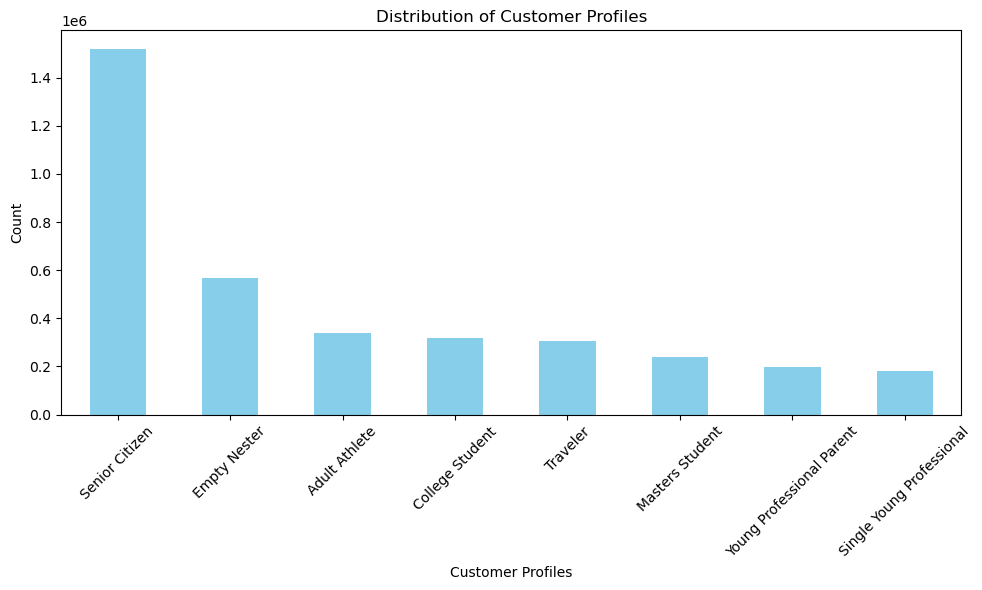

In [75]:

# Count the frequency of each customer profile
profile_counts = df_without_pii['customer_profile'].value_counts()

# Create a bar chart to visualize the distribution
hist = plt.figure(figsize=(10, 6))
profile_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Customer Profiles')
plt.xlabel('Customer Profiles')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


# Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure.

In [28]:

# Group the DataFrame by 'customer_profile'
customer_profile_grouped = df_without_pii.groupby('customer_profile')

# Calculate the maximum, mean, and minimum for 'income','age','number of dependants'
aggregates = customer_profile_grouped.agg({
    'total_income': ['max', 'mean', 'min'],
    'age': ['max', 'mean', 'min'],
    'number_of_dependants' : ['max','mean','min'],
    'number_of_orders': ['max','mean','min']
    
}).reset_index()

# Rename columns for clarity
aggregates.columns = ['customer_profile', 'max_income', 'mean_income', 'min_income',
                      'max_age', 'mean_age', 'min_age', 'max_dependants', 'mean_dependants', 'min_dependants','max_number_of_orders','mean_number_of_orders','min_number_of_orders']

# Display the aggregated data
print(aggregates)


            customer_profile  max_income    mean_income  min_income  max_age  \
0              Adult Athlete       80732   69768.825513       39834       32   
1            College Student       88778   77942.626228       35653       25   
2               Empty Nester      167293  130562.649388      107618       65   
3            Masters Student       93316   90239.750700       88603       39   
4             Senior Citizen      167593  141547.892086      110170       81   
5  Single Young Professional       76924   71228.788264       39834       32   
6                   Traveler       53757   42305.097008       35653       32   
7  Young Professional Parent       93316   90261.054138       88603       39   

    mean_age  min_age  max_dependants  mean_dependants  min_dependants  \
0  28.808873       25               0         0.000000               0   
1  20.573504       18               0         0.000000               0   
2  54.478440       46               0         0.000000   

 # Comparing your customer profiles with regions and departments.  

In [29]:
# first step is group by Customer Profiles, Regions, and Departments:
# Group by 'customer_profile', 'Region', and 'department_id' and calculate counts
grouped = df_without_pii.groupby(['customer_profile', 'Region', 'department_id'])['user_id'].count().reset_index()

# Display the grouped data
print(grouped)



              customer_profile    Region  department_id  user_id
0                Adult Athlete  Region 1              7    10447
1                Adult Athlete  Region 1             11     1527
2                Adult Athlete  Region 1             12     2608
3                Adult Athlete  Region 1             16    20292
4                Adult Athlete  Region 2              7    10204
..                         ...       ...            ...      ...
166  Young Professional Parent  Region 4              8      794
167  Young Professional Parent  Region 4             12     2504
168  Young Professional Parent  Region 4             16    20015
169  Young Professional Parent  Region 4             17     2640
170  Young Professional Parent  Region 4             18     1522

[171 rows x 4 columns]


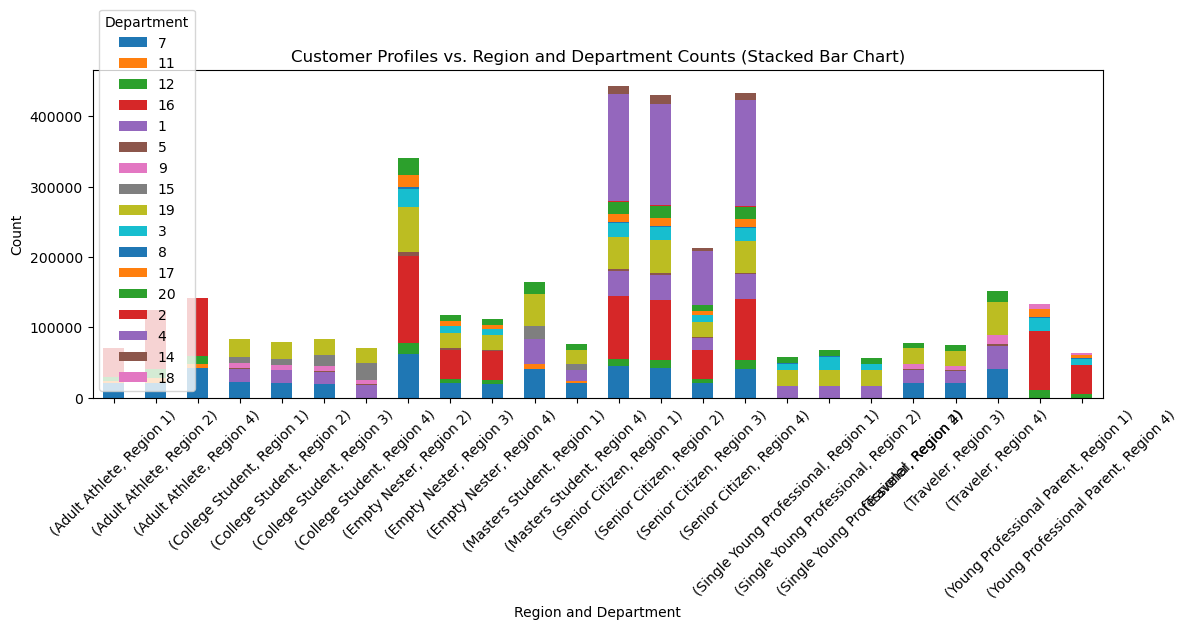

In [79]:


# Group by 'customer_profile', 'Region', and 'department_id' and calculate counts
grouped = df_without_pii.groupby(['customer_profile', 'Region', 'department_id'])['user_id'].count().unstack(fill_value=0)

# Create a stacked bar chart
stackedbar= grouped.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Customer Profiles vs. Region and Department Counts (Stacked Bar Chart)')
plt.xlabel('Region and Department')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Department')
plt.tight_layout()
plt.show()


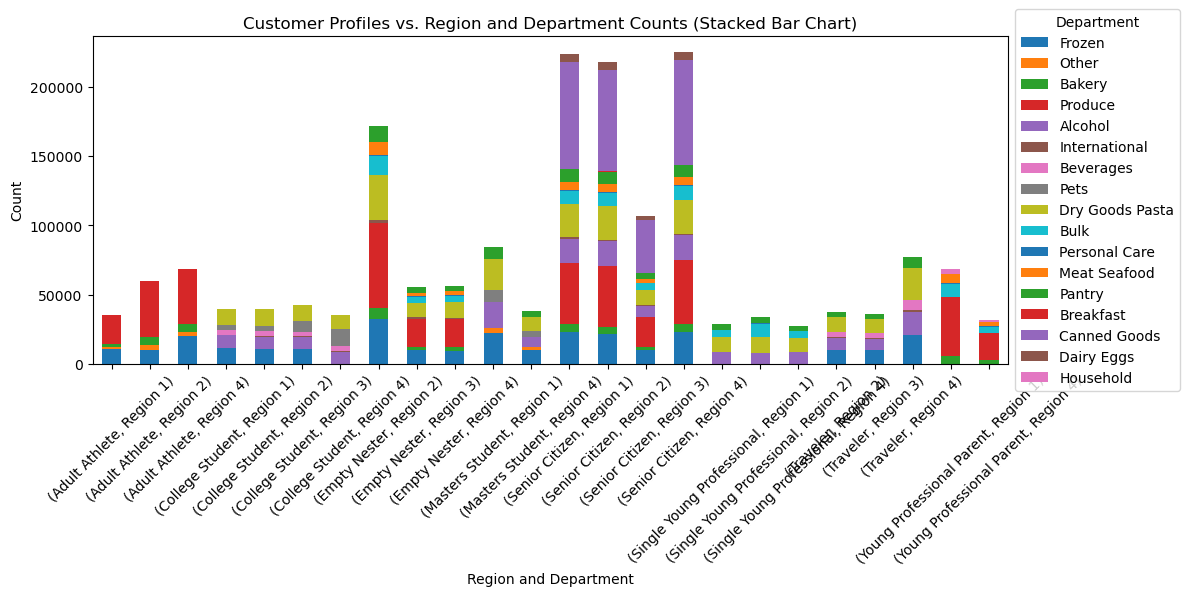

In [30]:
# Create a dictionary for department names
department_names = {
    1: 'Frozen',
    2: 'Other',
    3: 'Bakery',
    4: 'Produce',
    5: 'Alcohol',
    6: 'International',
    7: 'Beverages',
    8: 'Pets',
    9: 'Dry Goods Pasta',
    10: 'Bulk',
    11: 'Personal Care',
    12: 'Meat Seafood',
    13: 'Pantry',
    14: 'Breakfast',
    15: 'Canned Goods',
    16: 'Dairy Eggs',
    17: 'Household',
    18: 'Babies',
    19: 'Snacks',
    20: 'Deli',
    21: 'Missing'
}

# Create a dictionary for region names
region_names = {
    1: 'NORTHEAST',
    2: 'MIDWEST',
    3: 'SOUTH',
    4: 'WEST'
}

# Group by 'customer_profile', 'Region', and 'department_id' and calculate counts
grouped = df_without_pii.groupby(['customer_profile', 'Region', 'department_id'])['user_id'].count().unstack(fill_value=0)

# Create a stacked bar chart
stackedbar = grouped.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Customer Profiles vs. Region and Department Counts (Stacked Bar Chart)')
plt.xlabel('Region and Department')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Department', labels=[department_names[i] for i in range(1, 22)])
plt.legend(title='Department', labels=[department_names[i] for i in range(1, 22)], loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


In [78]:
# Saving the histogram  as a PNG
hist.figure.savefig(os.path.join(path, 'Analysis','Visualizations', 'histogram.png'))

In [81]:
# Saving the histogram  as a PNG
stackedbar.figure.savefig(os.path.join(path, 'Analysis','Visualizations', 'stacked_bar.png'))

In [32]:
crosstab = pd.crosstab(df_without_pii['days_since_prior_order'], df_without_pii['number_of_orders'], dropna = False)

In [33]:
crosstab.to_clipboard()

In [34]:
crosstab

number_of_orders,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
days_since_prior_order,,,,,,,,,,,,,,,,,,,,,
1.0,0,15693,14981,14040,13424,12631,12426,11382,10980,10262,...,1436,1358,1400,1417,1363,1352,1346,1317,1343,1163
2.0,0,23427,22779,21264,20127,19769,18801,19210,18040,17056,...,1990,1923,1735,1711,1752,1591,1469,1480,1729,1368
3.0,0,31576,31633,29766,28890,27619,27089,23960,23374,23445,...,1647,1726,1457,1411,1494,1074,1166,1127,958,1306
4.0,0,38653,38204,36781,35995,33866,31195,31152,29509,28294,...,1042,1184,1249,1013,871,986,910,983,872,881
5.0,0,45203,46720,44131,41455,38296,36982,34657,33238,31844,...,764,805,682,517,586,725,594,541,387,408
6.0,0,60071,61305,57329,53460,50501,47129,44377,42816,40427,...,386,359,451,629,281,252,225,351,271,287
7.0,0,91903,90099,83795,77197,71215,66994,63085,61096,57612,...,293,367,219,239,306,162,266,246,215,183
8.0,0,55045,54093,51264,46550,43854,40724,39179,34997,32895,...,121,167,140,113,112,105,114,118,45,51
9.0,0,36774,38544,34459,31730,29388,27049,25342,23065,21292,...,66,36,74,59,51,17,20,95,36,12


In [36]:
#checking consistency

# Create a cross-tabulation between 'fam_status' and 'frequency_flag'
cross_tab2 = pd.crosstab(df_without_pii['fam_status'], df_without_pii['frequency_flag'])

# Display the cross-tabulation
print(cross_tab2)


frequency_flag                    frequent_customer
fam_status                                         
divorced/widowed                            1167626
living with parents and siblings             264102
married                                    12202927
single                                      2503706


In [39]:
cross_tab2.to_clipboard()

In [40]:
cross_tab2

frequency_flag,frequent_customer
fam_status,
divorced/widowed,1167626
living with parents and siblings,264102
married,12202927
single,2503706


In [41]:
# checking consistency 
cross_tab3 = pd.crosstab(df_without_pii['fam_status'], df_without_pii['spending_flag'])


In [43]:
cross_tab3

spending_flag,High Spender,Low Spender
fam_status,,
divorced/widowed,523701,643925
living with parents and siblings,0,264102
married,2032891,10170036
single,254116,2249590


In [42]:
cross_tab3.to_clipboard()

In [44]:
# Create a cross-tabulation between 'busiest_day' and 'busiest_period_of_day'
cross_tab4 = pd.crosstab(df_without_pii['busiest_day'], df_without_pii['busiest_period_of_day'])

# Display the cross-tabulation
cross_tab4.to_clipboard()


In [45]:
cross_tab4

busiest_period_of_day,Average Orders,Lowest Orders,Most Orders
busiest_day,,,
Busiest day,890548,102775,2088899
Least busy,627920,82609,1171904
Regularly busy,3452374,457488,7263844


In [47]:
#exporting dataframe
# Export data to pkl

df_without_pii.to_pickle(os.path.join(path, 'Data','Prepared Data', 'final_dataframe_no_pii.pkl'))